## 🏹 | Challenge
- Use machine learning to design the energy supply strategy of green networks.
- Specify which energy source to use of grid, diesel or solar for each 15-minute slot of one week/ **Make the best use of the solar enegry when it is available.**
    - If selected energy source is insufficient, the battery will discharge to cover the shortfall.
    - conversely, any surplus energy will be stored in the battery.

# 📝 | Notes
- solar_zenith_angle, clearsky_dhi, relative_humidity, dhi are by magnitude smaller than the other variables, need for scaling preprocessing.
- There are five similar grid outage plans.

## 🤨 | Questions
- ~what is the relationship between the energy output and solar power statistics?~
- ~what times of the day is the most power produced?~
    - the clear sky affects the energy the most as expected and the most energy is produced at midday.
- ~what is the relationship between the solar energy output and the energy consumption?~
    - Solar energy is used when sufficient to power the site i.e. energy_outputkwh >=  total_energykwh
- ~what is the variation of the solar engery across the days in the data?~
- why is the data given in a day format?
- ~what is the grid outage plan?~
    - Hourly outage plan for a week.
- what is the relationship between energy_outputkwh, total_energykwh and grid_outage_plan?
    - Solar will be output as long as it available, the site will use the energy it needs, the grid will be off when it can. 
- ~what is the clear competition goal?~
    - Specify which energy source to use of grid, diesel or solar for each 15-minute slot of one week.
- Under what condition is the battery used?

## 💡 | Solution
- Forecast each of the variables for the week in question use (ARIMA models, Trees, NBeats, etc)

# 📚 | Libraries

In [1]:
import pandas as pd
from pathlib import Path
import warnings

# ⚙️ | Utilities

In [2]:
# Import utis module.
import utils
warnings.filterwarnings("ignore")

# 🗂️ | Data

The data includes the power supply of sites collected in different days. In more details, the data is divided into 3 datasets:

- **Site basic information and grid outage:** This dataset includes configuration parameters such as diesel output power (in kW) and battery capacity. It also covers grid-related parameters, including output power (in kW) and planned outages.
- **Solar power statistics:** Contains hourly data that details weather conditions (e.g., Direct Normal Irradiance (DNI), Diffuse Horizontal Irradiance (DHI), and Global Horizontal Irradiance (GHI)) along with the energy output measured in kilowatt-hours (kWh).
- **Energy consumption statistics:** Provides hour-by-hour energy consumption details, such as the total energy used by the base stations.

In [3]:
base_path = Path('data')
train_data_path = base_path/"trainData"
utils.print_folder_tree(base_path)

├── .DS_Store
├── SampleSubmission.csv
├── errorMetric_ex.py
├── manifest-981b91805c97d8bd0cdd65cf8d695b0d20240822-7912-1knfaac.json
├── trainData
│   ├── energy consumption.csv
│   ├── site information and grid outage.csv
│   └── solar power and weather condition.csv
└── .ipynb_checkpoints
    └── errorMetric_ex-checkpoint.py


### Site basic information and grid outage

In [4]:
site_information = utils.clean_column_names(pd.read_csv(train_data_path/'site information and grid outage.csv'))

# Convert grid outage to a list and convert strings to boolean.
site_information['grid_outage_plan'] = site_information['grid_outage_plan'].apply(
    lambda g: utils.convert_strings_to_booleans(g[1:-1].split())
)

site_information.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   site_id                        10 non-null     object 
 1   diesel_powerkw                 10 non-null     float64
 2   battery_capacity_ah            10 non-null     int64  
 3   rated_voltagev                 10 non-null     int64  
 4   battery_charge_coefficient     10 non-null     float64
 5   battery_discharge_coefficient  10 non-null     float64
 6   init_soc                       10 non-null     float64
 7   dod                            10 non-null     float64
 8   grid_powerkw                   10 non-null     int64  
 9   grid_outage_plan               10 non-null     object 
dtypes: float64(5), int64(3), object(2)
memory usage: 932.0+ bytes


In [5]:
site_information.head(3)

,site_id,diesel_powerkw,battery_capacity_ah,rated_voltagev,battery_charge_coefficient,battery_discharge_coefficient,init_soc,dod,grid_powerkw,grid_outage_plan
0,site1,18.0,300,54,0.35,1.2,0.2,0.15,8,"[False, False, False, False, False, False, Fal..."
1,site2,17.6,760,54,0.35,1.2,0.2,0.15,14,"[False, False, False, False, False, False, Fal..."
2,site3,12.8,760,54,0.35,1.2,0.2,0.15,10,"[False, False, False, False, False, False, Fal..."


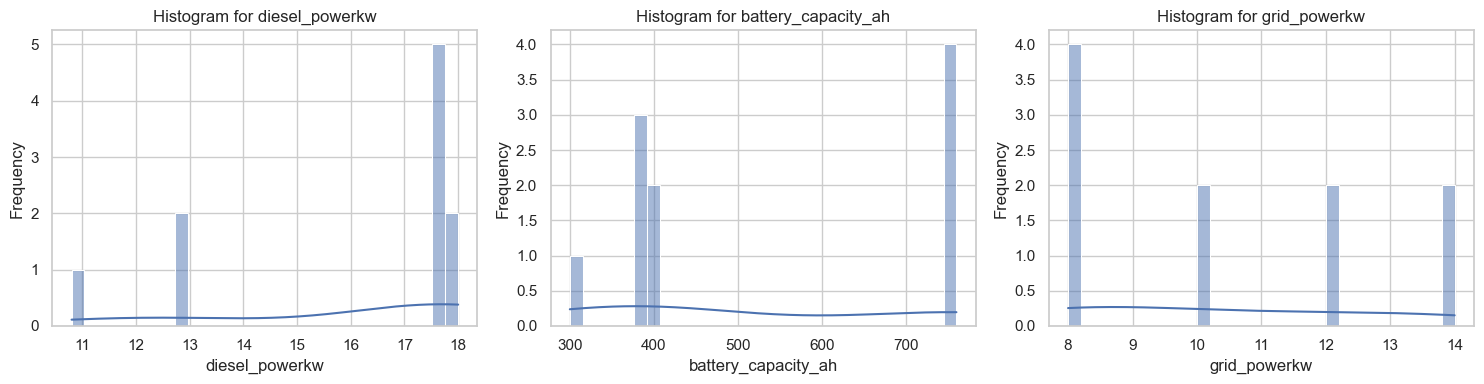

In [6]:
# Plot of distributions for numeric
utils.plot_histograms(site_information)

In [7]:
# utils.plot_boxplot(site_information, variables=['diesel_powerkw',
#        'battery_charge_coefficient', 'battery_discharge_coefficient',
#        'init_soc', 'dod', 'grid_powerkw', 'grid_outage_plan'], figsize=(12, 5))

### Grid outage plan

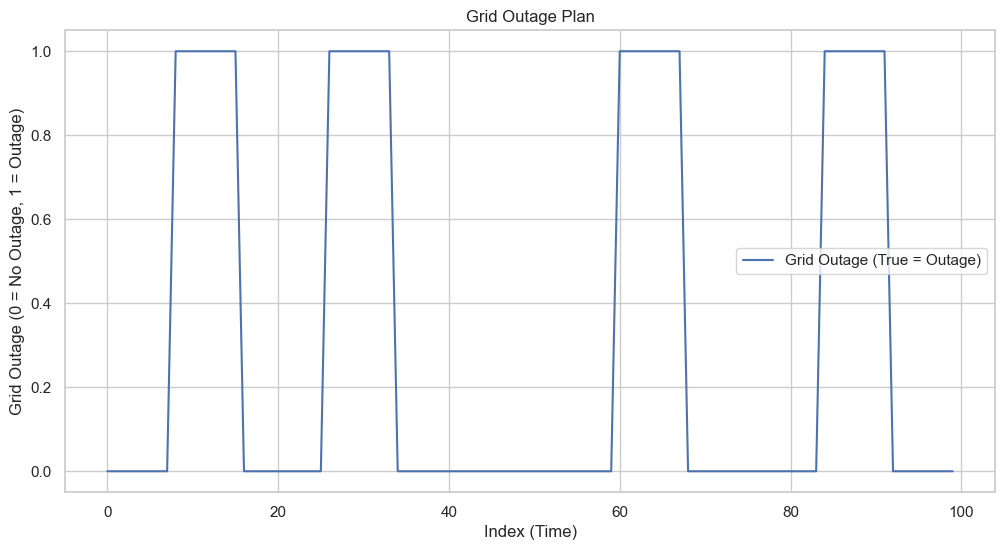

In [8]:
utils.plot_grid_outage(site_information.loc[0, 'grid_outage_plan'], end=100)

### Solar power statistics

In [9]:
solar_power_statistics = utils.clean_column_names(pd.read_csv(train_data_path/"solar power and weather condition.csv"))

In [10]:
solar_power_statistics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14400 entries, 0 to 14399
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   site_name           14400 non-null  object 
 1   day                 14400 non-null  int64  
 2   hour                14400 non-null  int64  
 3   solar_zenith_angle  14400 non-null  float64
 4   clearsky_dhi        14400 non-null  float64
 5   clearsky_dni        14400 non-null  float64
 6   clearsky_ghi        14400 non-null  float64
 7   relative_humidity   14400 non-null  float64
 8   dhi                 14400 non-null  float64
 9   dni                 14400 non-null  float64
 10  ghi                 14400 non-null  float64
 11  energy_outputkwh    14400 non-null  float64
dtypes: float64(9), int64(2), object(1)
memory usage: 1.3+ MB


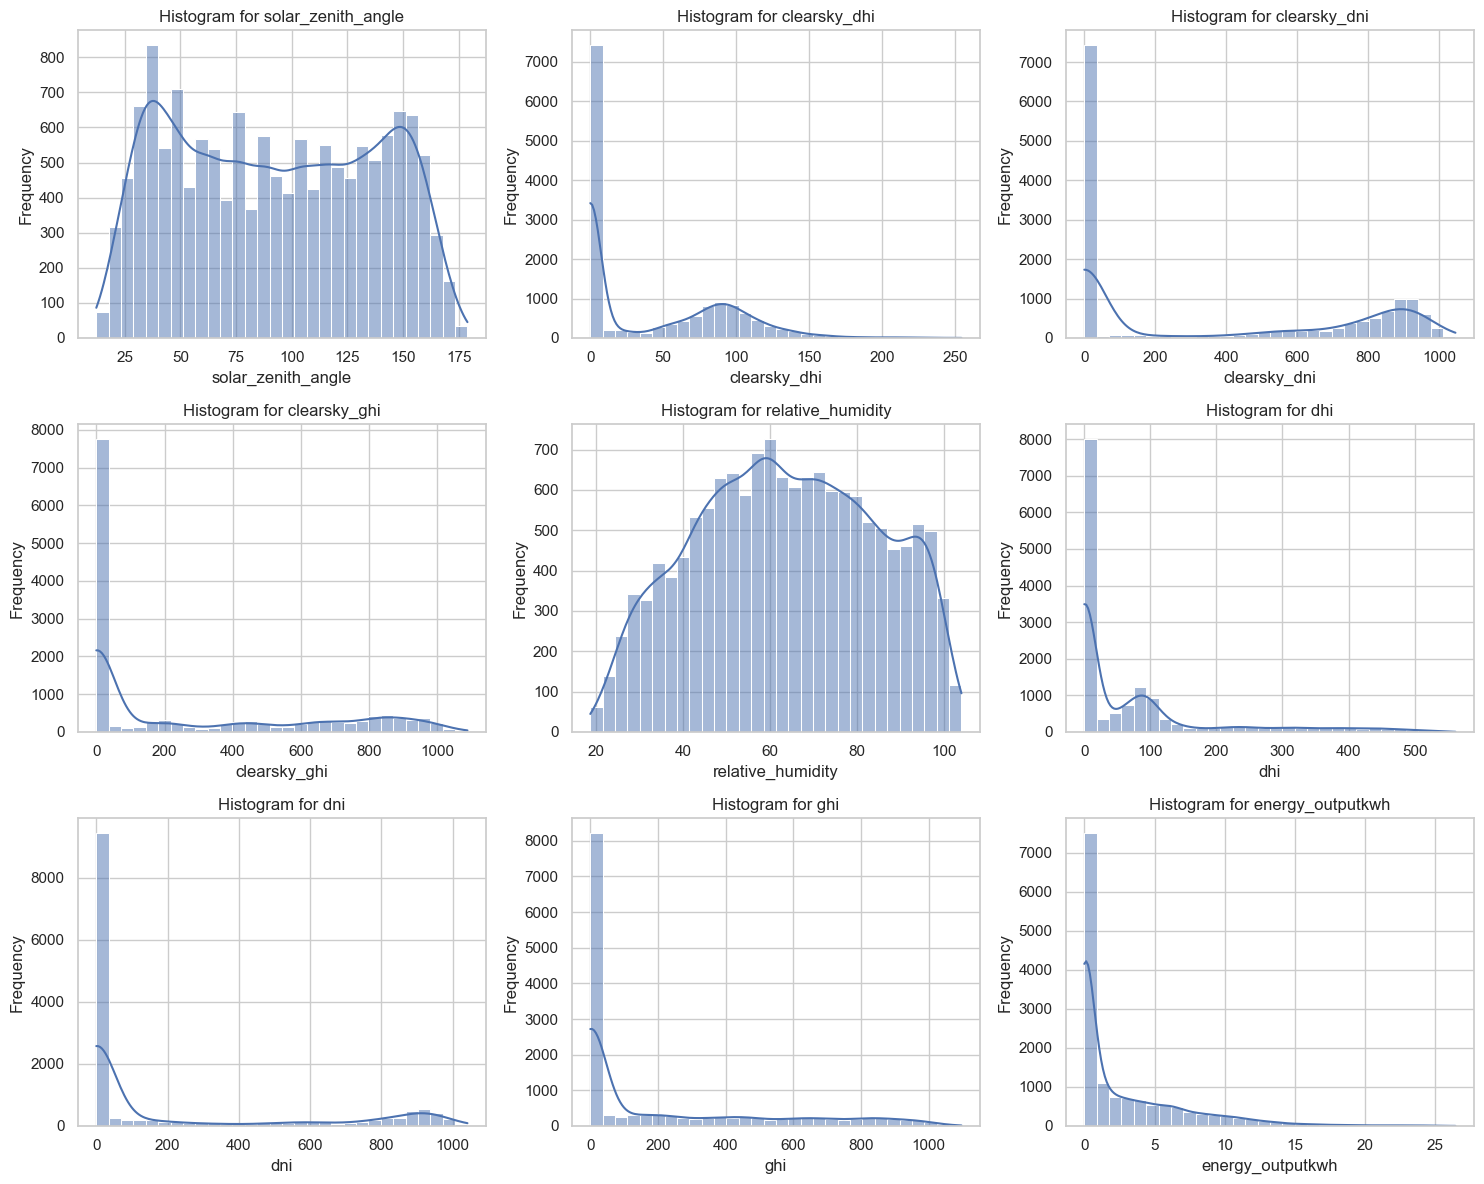

In [11]:
utils.plot_histograms(solar_power_statistics, skip_columns=['day', 'hour'])

In [12]:
# How many unique days? ->Two months of data.
solar_power_statistics['day'].nunique()

60

In [13]:
# And the days?
solar_power_statistics['hour'].nunique()

24

How many unique days?  
Two months of data, 24 hours a day.

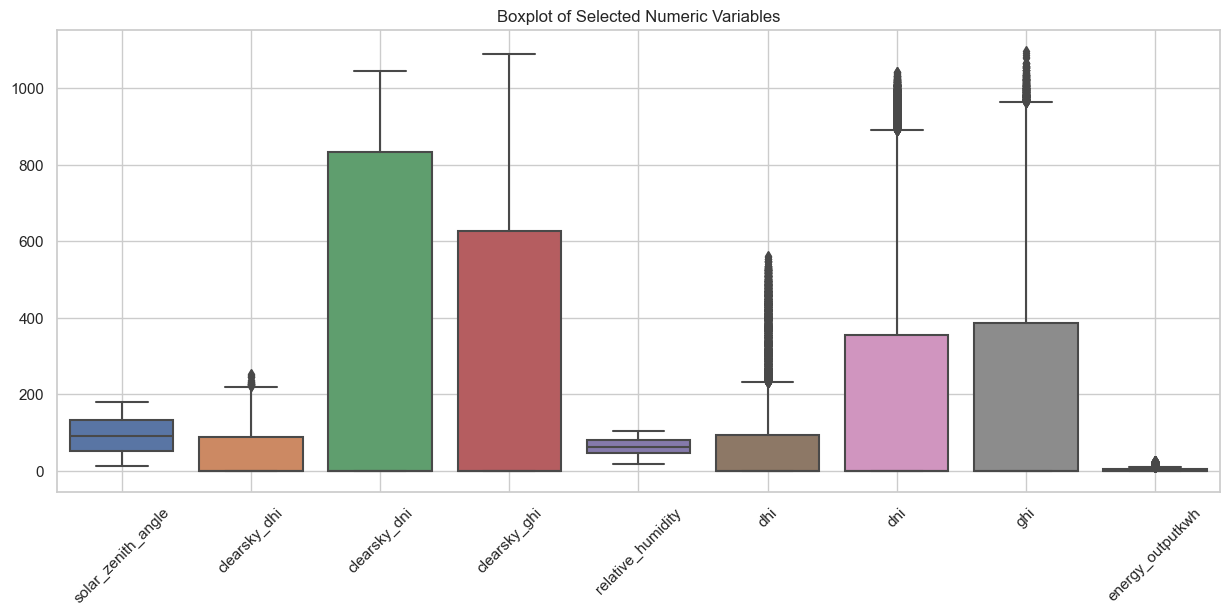

In [14]:
utils.plot_boxplot(solar_power_statistics, variables=['solar_zenith_angle', 'clearsky_dhi',
       'clearsky_dni', 'clearsky_ghi', 'relative_humidity', 'dhi', 'dni',
       'ghi', 'energy_outputkwh'], figsize=(15, 6))

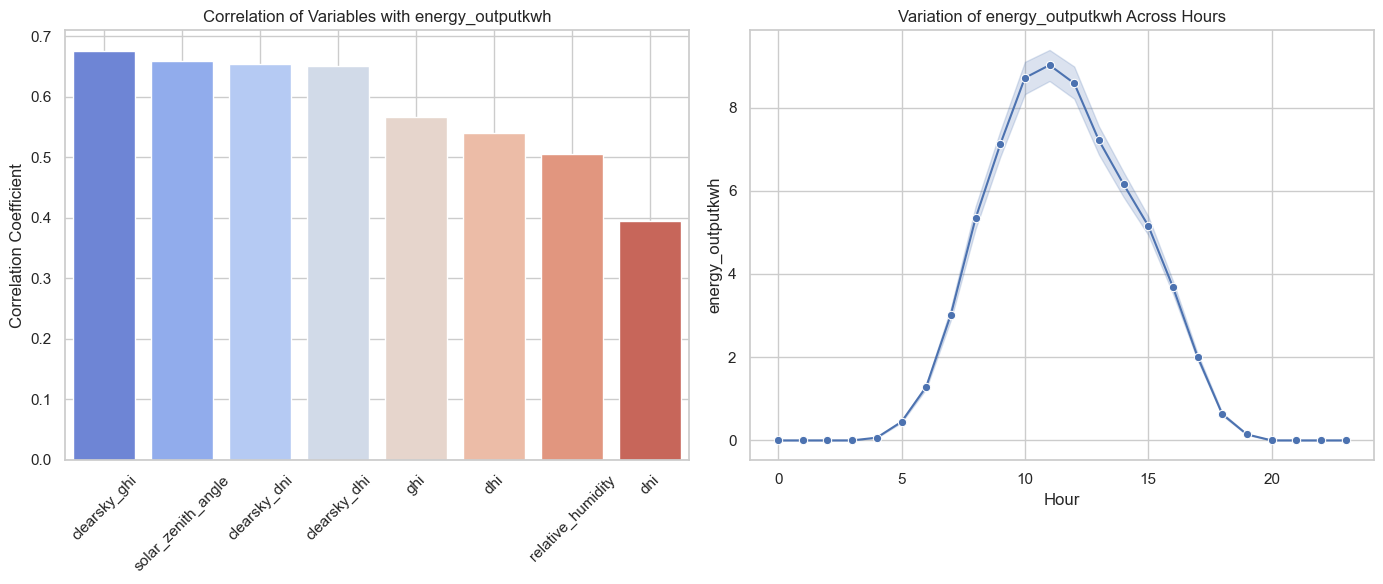

In [15]:
utils.plot_correlation_and_hour_variation(solar_power_statistics)

- the clear sky affects the energy the most as expected and the hours of the day as expected.

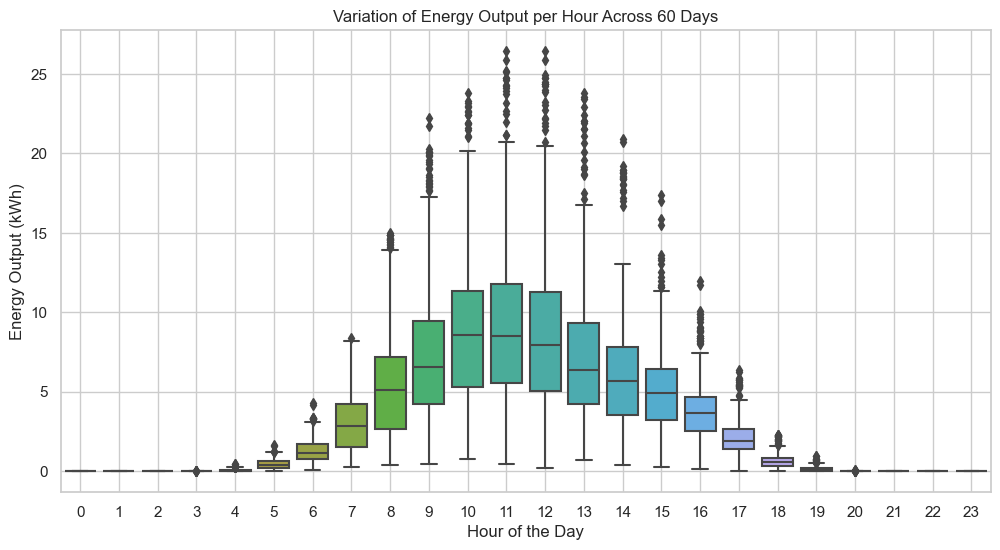

In [16]:
utils.plot_hourly_energy_variation(solar_power_statistics)

### Time Series Visualization
Plot the time series data and try to identify:
- any patterns
- and peak hours
- and any other learnings

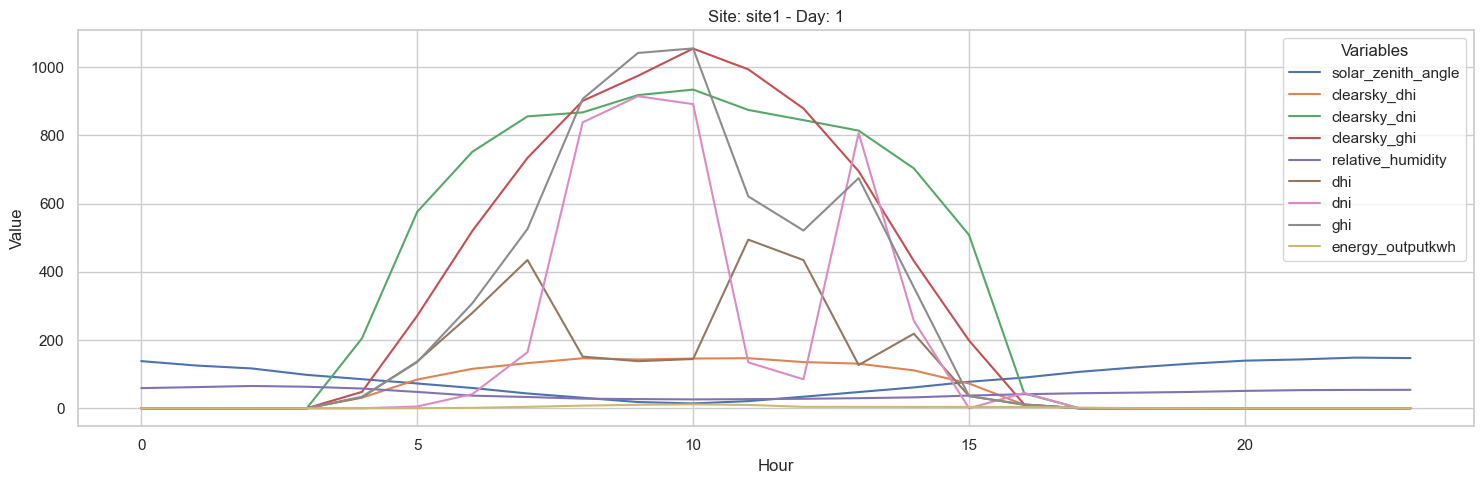

In [17]:
utils.plot_site_variables(
    site_name='site1', 
    site_data=solar_power_statistics, 
    days=list(range(1,2)),
    figsize=(15, 5),
    n_cols=1
)

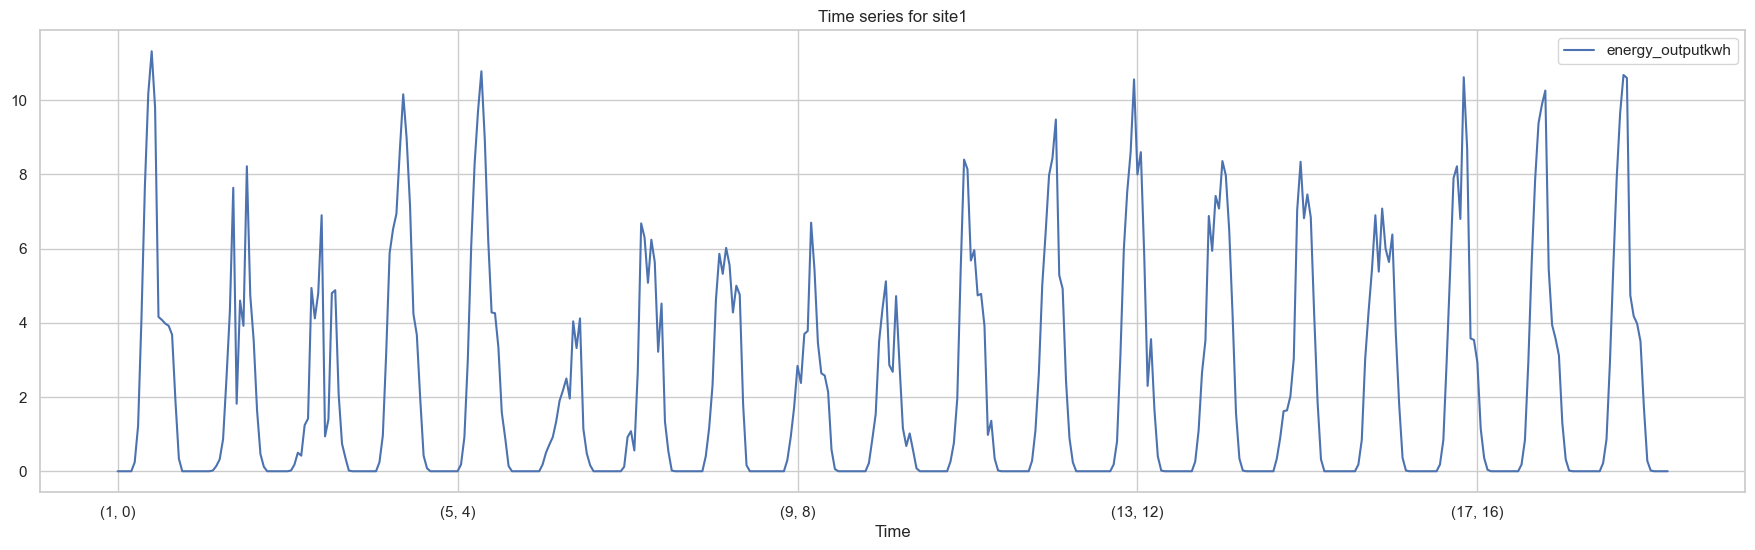

In [18]:
utils.plot_time_series_site_variables(
    solar_power_statistics, 'site1', variables=['energy_outputkwh'], start=(1,0), end=(20,0), figsize=(22,6))

### Energy Consumption
Provides hour-by-hour energy consumption details, such as the total energy used by the base stations.

In [19]:
energy_consumption = utils.clean_column_names(pd.read_csv(train_data_path/"energy consumption.csv"))

In [20]:
energy_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14400 entries, 0 to 14399
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   site_name        14400 non-null  object 
 1   day              14400 non-null  int64  
 2   hour             14400 non-null  int64  
 3   total_energykwh  14400 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 450.1+ KB


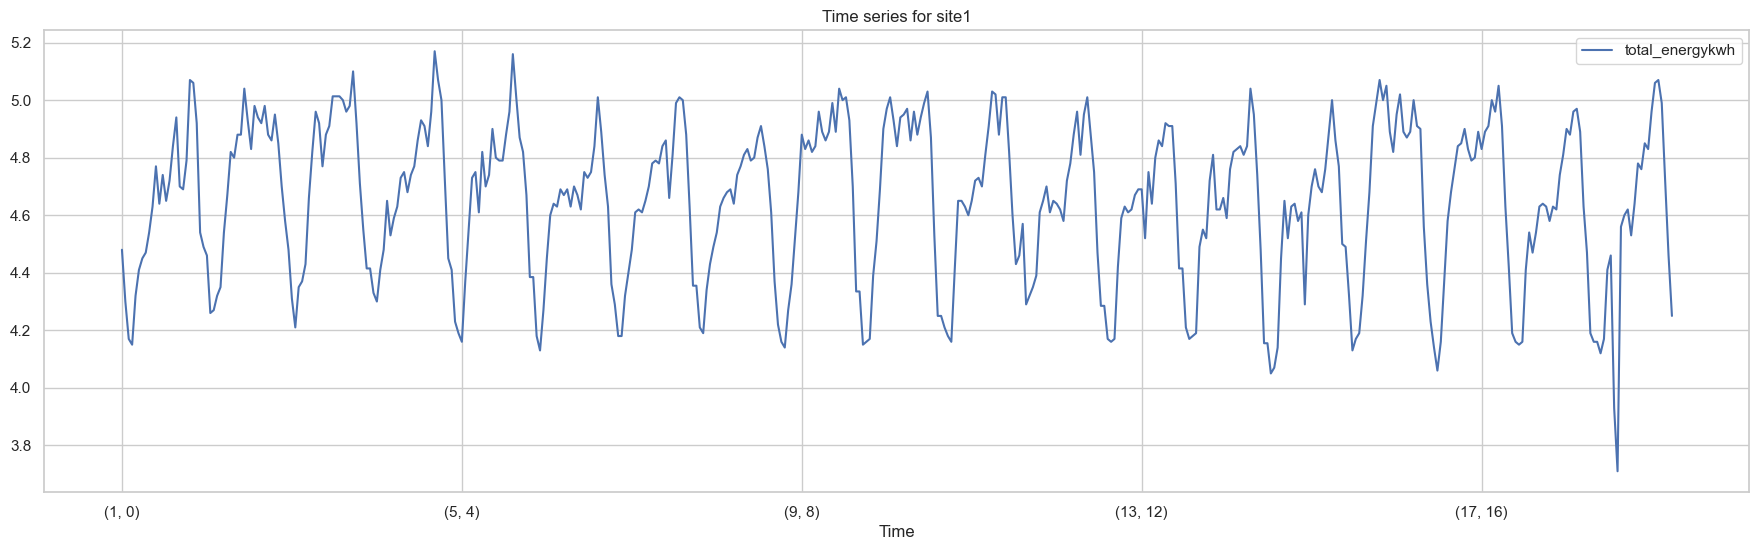

In [21]:
utils.plot_time_series_site_variables(
    energy_consumption, 'site1', variables=['total_energykwh'], start=(1,0), end=(20,0), figsize=(22,6))

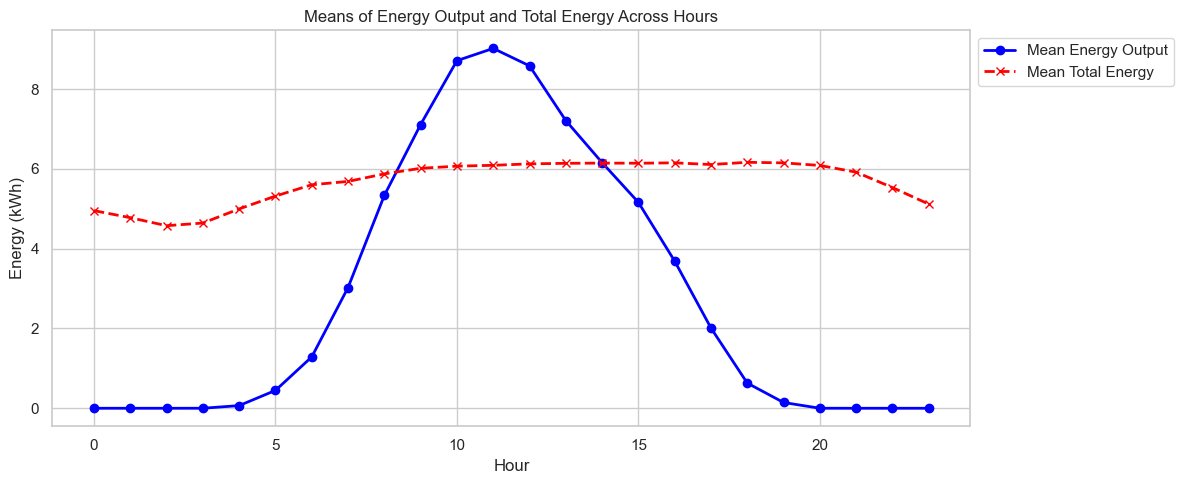

In [22]:
utils.plot_means(energy_consumption, solar_power_statistics, figsize=(12, 5))

# 🤿 | A dive into total energy supply i.e. solar, grid, battery and diesel
### Equations
Battery SOC change rate: $$\displaystyle c_t =  \frac{\Delta SOC_t}{\Delta t} = \frac{(totalSupply_t - load_t) \times coefficient}{(rated\ capacity \times rated\ voltage)}$$
- If $SOC_t < DOD$ at any time, the solution is not valid.
- Use charge coefficient when total_supply >= load, use charging coefficient, when total_supply < load, the batter discharges.

Total Energy from battery:
$$
\text{Energy (Wh)} = \text{Capacity (Ah)} \times \text{Voltage (V)}
$$

Generator power:
$$
\text{Energy (kWh)} = \text{Diesel (kW)} \times \text{time (h)}
$$


### Considerations
- [How does the site work?](https://zindi.africa/competitions/smart-energy-supply-scheduling-for-green-telecom/discussions/21933)
- [Grid outage is the same per week including the test week.](https://zindi.africa/competitions/smart-energy-supply-scheduling-for-green-telecom/discussions/21970)

Unclear:- when is the battery used? Use the generator only when absolutely necessary, when no solar, battery, grid.

In [23]:
# Create soc variables times series, start with solar.
soc_time_series = solar_power_statistics[
    ['site_name', 'day', 'hour', 'energy_outputkwh']
].copy().rename(columns={'energy_outputkwh':'solar_kwh'})

# Add grid power
soc_time_series['grid_kwh'] = soc_time_series.apply(utils.get_grid_powerkw, site_information=site_information, axis=1)

# Add the load.
soc_time_series = pd.merge(
    left=soc_time_series,
    right=energy_consumption.rename(columns={"total_energykwh":"load"}),
    on=['site_name', 'day', 'hour']
)

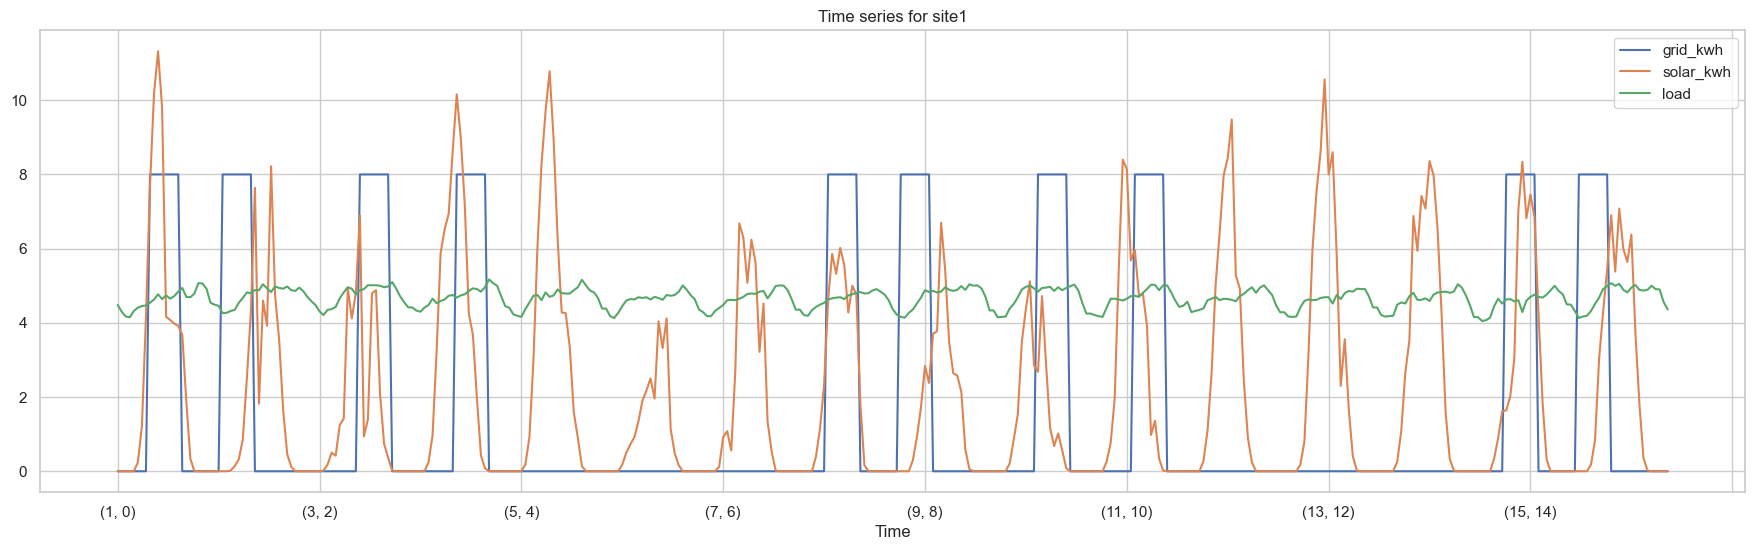

In [24]:
# what does this look like sofar?
utils.plot_time_series_site_variables(
    soc_time_series, 'site1', variables=['grid_kwh', 'solar_kwh', 'load'], start=(1,0), end=(17,0), figsize=(22,6))

In [25]:
# soc for site 1
init_soc = 0.2
battery_charge_coefficient = 0.35
battery_discharge_coefficient = 1.2
rated_voltagev = 54
battery_capacity_ah = 300
total_energy_kwh = rated_voltagev * battery_capacity_ah
dod = 0.15

In [26]:
total_energy_kwh / 1000

16.2

In [27]:
utils.calculate_ct(
    total_supply_i=0, 
    load_t=4.48, 
    battery_discharge_coefficient=battery_discharge_coefficient, 
    battery_charge_coefficient=battery_charge_coefficient,
    rated_capacity=battery_capacity_ah,
    rated_voltage=rated_voltagev
)

-0.3318518518518519

In [28]:
site_one_soc_ts = soc_time_series.query(f"site_name == 'site1'")
site_one_soc_ts.head(5)

,site_name,day,hour,solar_kwh,grid_kwh,load
0,site1,1,0,0.0,0,4.48
1,site1,1,1,0.0,0,4.30
2,site1,1,2,0.0,0,4.17
3,site1,1,3,0.0,0,4.15
4,site1,1,4,0.0,0,4.32


In [29]:
site_one_soc_ts['generator_kwh'] = 18

In [30]:
# We don't want to use the generator, so we will use it to charge the battery.
site_one_soc_ts.head(2)

,site_name,day,hour,solar_kwh,grid_kwh,load,generator_kwh
0,site1,1,0,0.0,0,4.48,18
1,site1,1,1,0.0,0,4.30,18


# 🏃🏾 | First Run at energy optimization

In [31]:
from optimization import run_optimization, EnergyOptimizer

In [34]:
# Example usage:
battery_capacity = 300  # Ah
rated_voltage = 54  # V
charge_coefficient = 0.35
discharge_coefficient = 1.2
init_soc = 0.2
dod = 0.15
generator_power_kw = 18

optimizer = EnergyOptimizer(battery_capacity, rated_voltage, charge_coefficient, 
                            discharge_coefficient, init_soc, dod, generator_power_kw)

results = run_optimization(
    site_one_soc_ts.solar_kwh.values, 
    site_one_soc_ts.grid_kwh.values, 
    site_one_soc_ts.load.values, 
    optimizer
)

In [36]:
# results